# Notebook Plan: EEG Eye State Classification (Clean & High Accuracy)

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import helper_functions



## Load Dataset

In [3]:
data = pd.read_csv("EEG_Eye_State_Classification.csv")

X_raw = data.drop(columns=["eyeDetection"])
y_raw = data["eyeDetection"]

print(X_raw.shape, y_raw.shape)


(14980, 14) (14980,)


In [4]:
X_raw.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000


## Minimal Preprocessing

In [5]:
from scipy.stats import zscore

X_norm = X_raw.apply(zscore)

## Create Windows

In [6]:
WINDOW_SEC = 2
OVERLAP = 0.75

X_windows, y_windows = helper_functions.create_windows(
    X_norm,
    y_raw,
    window_size=WINDOW_SEC,
    overlap=OVERLAP,
    sfreq=128
)

print(X_windows.shape)
print(pd.Series(y_windows).value_counts())


(231, 256, 14)
0    128
1    103
Name: count, dtype: int64


## Feature Extraction

In [7]:
channel_names = X_norm.columns.tolist()

In [8]:
X_features = helper_functions.features_all_windows(
    X_windows,
    channel_names,
    sfreq=128
)

print(X_features.shape)
X_features.head()


(231, 182)


,AF3_delta_abs,AF3_theta_abs,AF3_alpha_abs,AF3_beta_abs,AF3_gamma_abs,AF3_spectral_centroid,AF3_spectral_entropy,AF3_mean,AF3_std,AF3_var,...,AF4_beta_abs,AF4_gamma_abs,AF4_spectral_centroid,AF4_spectral_entropy,AF4_mean,AF4_std,AF4_var,AF4_skewness,AF4_shannon_entropy,AF4_zcr
0,17.584701,0.348879,0.126949,0.117325,0.042637,1.113934,2.425869,0.006649,0.023465,0.000551,...,0.027146,0.012145,1.088316,1.828488,-0.001156,0.010753,0.000116,1.130150,1.836126,0.007843
1,18.624608,0.367654,0.099931,0.113227,0.042470,1.114965,2.316648,0.007377,0.024117,0.000582,...,0.030498,0.009272,1.189788,1.823749,-0.000433,0.010643,0.000113,0.971661,1.998369,0.031373
2,16.885665,0.395045,0.071257,0.114507,0.038427,0.963106,2.415825,0.010534,0.022965,0.000527,...,0.024457,0.009810,1.233747,2.026909,0.000919,0.009807,0.000096,0.989064,2.058376,0.047059
3,3.932216,0.586051,0.188071,0.210344,0.074479,3.578758,3.412009,0.001206,0.011992,0.000144,...,0.053958,0.021309,2.542060,3.255582,-0.002812,0.006406,0.000041,1.480235,1.869201,0.043137
4,3.505465,0.157799,0.039202,0.106750,0.026678,1.521491,2.427911,-0.003369,0.010714,0.000115,...,0.023992,0.007493,0.411963,1.060161,-0.006542,0.004168,0.000017,0.304793,2.105892,0.039216


In [9]:
X = X_features.values
y = np.array(y_windows)

In [10]:
models = {
    "SVM": (
        SVC(kernel="rbf", class_weight="balanced", random_state=42),
        {
            "clf__C": [1, 10, 100],
            "clf__gamma": [0.01, 0.001]
        }
    ),

    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),

    "KNN": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [3, 5, 7, 9]
        }
    ),
    "Logistic Regression": (
        LogisticRegression(class_weight="balanced", max_iter=1000, penalty="l2", solver="lbfgs", random_state=42),
        {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__class_weight": [None, "balanced"]
        }
    )
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [11]:
results_4_3 = {}

for name, (model, param_grid) in models.items():
    print(f"\n==============================")
    print(f"Model: {name}")
    print(f"==============================")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(X, y)

    best_model = grid.best_estimator_

    fold_accuracies = []
    y_true_all = []
    y_pred_all = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        fold_accuracies.append(accuracy_score(y_test, y_pred))
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    fold_accuracies = np.array(fold_accuracies)

    print(f"Mean Accuracy: {fold_accuracies.mean() * 100:.2f}% +/- {fold_accuracies.std() * 100:.2f}%")
    print("Best Params :", grid.best_params_)

    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all))

    print("Confusion Matrix:")
    print(confusion_matrix(y_true_all, y_pred_all))

    results_4_3[name] = {
        "fold_accuracies": fold_accuracies,
        "mean_accuracy": fold_accuracies.mean(),
        "std_accuracy": fold_accuracies.std(),
        "best_params": grid.best_params_
    }



Model: SVM
Mean Accuracy: 88.28% +/- 6.48%
Best Params : {'clf__C': 100, 'clf__gamma': 0.01}

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       128
           1       0.87      0.87      0.87       103

    accuracy                           0.88       231
   macro avg       0.88      0.88      0.88       231
weighted avg       0.88      0.88      0.88       231

Confusion Matrix:
[[114  14]
 [ 13  90]]

Model: Random Forest
Mean Accuracy: 87.03% +/- 6.40%
Best Params : {'clf__max_depth': 10, 'clf__n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       128
           1       0.89      0.81      0.85       103

    accuracy                           0.87       231
   macro avg       0.87      0.86      0.87       231
weighted avg       0.87      0.87      0.87       231

Confusion Matrix:
[[118  10]
 [ 20  83]]

Mode

c:\Users\ahmed_abdulhakeem\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ahmed_abdulhakeem\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\ahmed_abdulhakeem\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmed_abdulhakeem\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, clos

Mean Accuracy: 84.82% +/- 5.28%
Best Params : {'clf__n_neighbors': 3}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       128
           1       0.83      0.83      0.83       103

    accuracy                           0.85       231
   macro avg       0.85      0.85      0.85       231
weighted avg       0.85      0.85      0.85       231

Confusion Matrix:
[[110  18]
 [ 17  86]]

Model: Logistic Regression
Mean Accuracy: 81.79% +/- 7.77%
Best Params : {'clf__C': 10, 'clf__class_weight': None}

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       128
           1       0.80      0.80      0.80       103

    accuracy                           0.82       231
   macro avg       0.82      0.82      0.82       231
weighted avg       0.82      0.82      0.82       231

Confusion Matrix:
[[107  21]
 [ 21  82]]


In [15]:
from scipy.stats import wilcoxon

svm_acc = results_4_3["SVM"]["fold_accuracies"]
rf_acc  = results_4_3["Random Forest"]["fold_accuracies"]
knn_acc = results_4_3["KNN"]["fold_accuracies"]
lr_acc  = results_4_3["Logistic Regression"]["fold_accuracies"]

print("SVM vs RF:", wilcoxon(svm_acc, rf_acc))
print("SVM vs KNN:", wilcoxon(svm_acc, knn_acc))
print("RF vs KNN :", wilcoxon(rf_acc, knn_acc))
print("SVM vs LR:", wilcoxon(svm_acc, lr_acc))
print("RF vs LR :", wilcoxon(rf_acc, lr_acc))
print("KNN vs LR:", wilcoxon(knn_acc, lr_acc))


SVM vs RF: WilcoxonResult(statistic=np.float64(7.0), pvalue=np.float64(0.53125))
SVM vs KNN: WilcoxonResult(statistic=np.float64(10.5), pvalue=np.float64(0.0859375))
RF vs KNN : WilcoxonResult(statistic=np.float64(5.0), pvalue=np.float64(0.140625))
SVM vs LR: WilcoxonResult(statistic=np.float64(2.0), pvalue=np.float64(0.015625))
RF vs LR : WilcoxonResult(statistic=np.float64(1.0), pvalue=np.float64(0.0078125))
KNN vs LR: WilcoxonResult(statistic=np.float64(11.0), pvalue=np.float64(0.3828125))


C:\Users\ahmed_abdulhakeem\AppData\Local\Temp\ipykernel_17752\2158692097.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


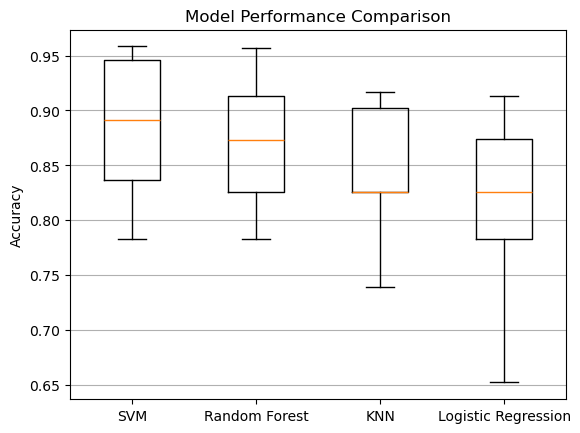

In [14]:
import matplotlib.pyplot as plt

plt.boxplot(
    [svm_acc, rf_acc, knn_acc, lr_acc],
    labels=["SVM", "Random Forest", "KNN", "Logistic Regression"]
)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.grid(axis="y")
plt.show()


- Wilcoxon signed-rank tests revealed no statistically significant differences between the evaluated classifiers (p ≥ 0.05 for all pairwise comparisons) expet for logistic reggrission, indicating comparable performance across models.

- there is statistically significant differences between logistic reggrission and (random forest and SVM)

- Although SVM achieved the highest mean accuracy, the observed differences were not statistically significant.